In [1]:
# Library dasar untuk data
import numpy as np
import pandas as pd
import os

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # Untuk "gambar kata-kata gede"

# Library untuk Natural Language Toolkit (NLTK)
import re
import string
import emoji
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Library untuk Machine Learning (sklearn)
from sklearn.feature_extraction.text import TfidfVectorizer # Metode TF-IDF
from sklearn.linear_model import LogisticRegression      # Model Logistic Regression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Setting agar plot tampil di notebook
%matplotlib inline

In [2]:
# Download modul NLTK yang diperlukan (hanya perlu sekali)
print("Downloading NLTK resources...")
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt', quiet=True)
print("NLTK resources downloaded.")

NLTK resources downloaded.


In [5]:
# Ganti nama file dari 'twitter_...' menjadi file IMDb
try:
    df_train = pd.read_csv("./train_data (1).csv")
    df_val = pd.read_csv("./test_data (1).csv")
    print("\nDataset 'train.csv' dan 'test.csv' berhasil dimuat.")
except FileNotFoundError:
    print("\n[Error] Pastikan file 'train.csv' dan 'test.csv' ada di folder yang sama dengan notebook ini.")
    df_train = pd.DataFrame(columns=['0', '1'])
    df_val = pd.DataFrame(columns=['0', '1'])


Dataset 'train.csv' dan 'test.csv' berhasil dimuat.


In [6]:
# 1. Ganti nama kolom
df_train = df_train.rename(columns={'0': 'text', '1': 'sentimen'})
df_val = df_val.rename(columns={'0': 'text', '1': 'sentimen'})

# 2. Mapping label angka ke teks (agar sama seperti alur aslimu)
label_map = {1: 'Positive', 0: 'Negative'}
df_train['sentimen'] = df_train['sentimen'].map(label_map)
df_val['sentimen'] = df_val['sentimen'].map(label_map)

print("Nama kolom dan label berhasil disesuaikan.")

Nama kolom dan label berhasil disesuaikan.


In [7]:
print("\n--- 5 Data Teratas (Data Training) ---")
display(df_train.head())

print("\n--- Info DataFrame (Data Training) ---")
df_train.info()

print("\n--- Cek Data Hilang (Data Training) ---")
print(df_train.isna().sum())


--- 5 Data Teratas (Data Training) ---


,text,sentimen
0,"This film is absolutely awful, but nevertheles...",Negative
1,Well since seeing part's 1 through 3 I can hon...,Negative
2,I got to see this film at a preview and was da...,Positive
3,This adaptation positively butchers a classic ...,Negative
4,Råzone is an awful movie! It is so simple. It ...,Negative



--- Info DataFrame (Data Training) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      25000 non-null  object
 1   sentimen  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB

--- Cek Data Hilang (Data Training) ---
text        0
sentimen    0
dtype: int64


In [8]:
# Fungsi untuk membersihkan DataFrame
def clean_dataframe(df):
    print(f"Bentuk data SEBELUM cleaning: {df.shape}")

    # Hapus baris yang punya '?', '', atau NaN
    for col in df.columns:
        if df[col].dtype == 'object': # Hanya cek kolom teks
            df = df[df[col] != '?']
            df = df[df[col] != '']
    df = df.dropna() # Hapus semua baris NaN

    # Hapus duplikat
    df.drop_duplicates(keep='first', inplace=True)

    print(f"Bentuk data SETELAH cleaning: {df.shape}")
    return df

In [9]:
print("--- Membersihkan Data Training ---")
df_train = clean_dataframe(df_train)

print("\n--- Membersihkan Data Validasi ---")
df_val = clean_dataframe(df_val)

--- Membersihkan Data Training ---
Bentuk data SEBELUM cleaning: (25000, 2)
Bentuk data SETELAH cleaning: (24904, 2)

--- Membersihkan Data Validasi ---
Bentuk data SEBELUM cleaning: (25000, 2)
Bentuk data SETELAH cleaning: (24801, 2)



Menampilkan plot distribusi sentimen...


/tmp/ipython-input-2386486850.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimen', data=df_train, palette=['#FF7F0E', '#1F77B4']) # Oranye untuk Negatif, Biru untuk Positif
/tmp/ipython-input-2386486850.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimen', data=df_val, palette=['#FF7F0E', '#1F77B4'])


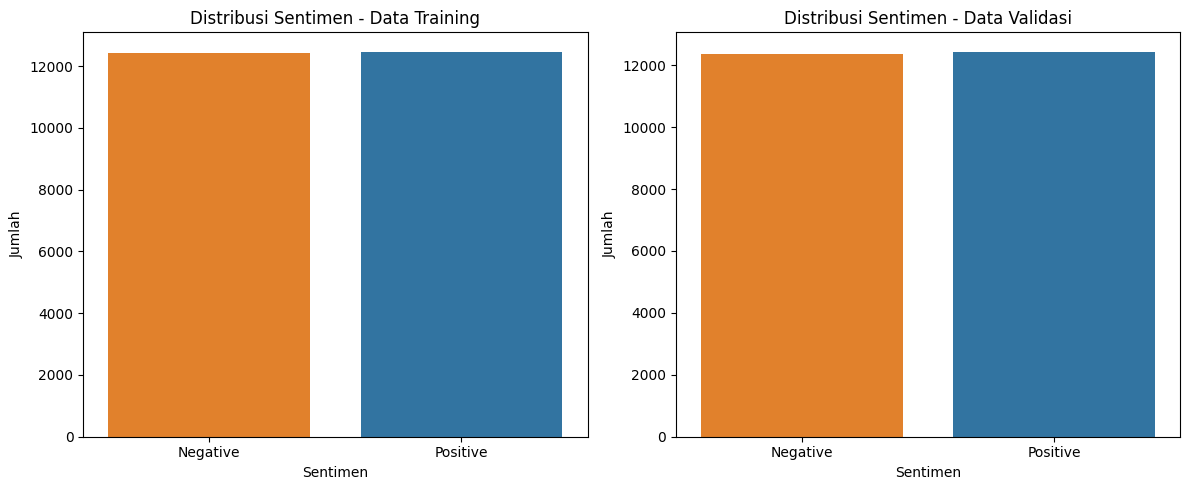

In [10]:
print("\nMenampilkan plot distribusi sentimen...")
plt.figure(figsize=(12, 5))

# Plot untuk Data Training
plt.subplot(1, 2, 1)
sns.countplot(x='sentimen', data=df_train, palette=['#FF7F0E', '#1F77B4']) # Oranye untuk Negatif, Biru untuk Positif
plt.title('Distribusi Sentimen - Data Training')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

# Plot untuk Data Validasi
plt.subplot(1, 2, 2)
sns.countplot(x='sentimen', data=df_val, palette=['#FF7F0E', '#1F77B4'])
plt.title('Distribusi Sentimen - Data Validasi')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')

plt.tight_layout()
plt.show()

In [11]:
print("\nMempersiapkan fungsi-fungsi preprocessing teks...")

# Inisialisasi stopwords (kata-kata umum) dan lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Kamus singkatan (sama seperti di notebook-mu)
abbreviation_map = {
    "u": "you", "ur": "your", "r": "are", "btw": "by the way",
    "idk": "i do not know", "imo": "in my opinion", "imho": "in my humble opinion",
    "lol": "laughing out loud", "omg": "oh my god", "thx": "thanks",
    "pls": "please", "plz": "please", "dont": "do not", "cant": "cannot",
    "wont": "will not", "ive": "i have", "ill": "i will", "didnt": "did not",
    "doesnt": "does not", "isnt": "is not", "wasnt": "was not",
    "havent": "have not", "shouldnt": "should not", "couldnt": "could not",
    "wouldnt": "would not",
}

def get_wordnet_pos(word):
    """Fungsi helper untuk dapat Part-of-Speech (POS) tag."""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,
        'N': wordnet.NOUN,
        'V': wordnet.VERB,
        'R': wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    """Fungsi utama untuk membersihkan teks."""
    if not isinstance(text, str):
        text = str(text)

    text = text.lower() # 1. Ubah ke huruf kecil
    text = emoji.demojize(text) # 2. Ubah emoji jadi teks
    text = re.sub(r'http\S+|www\S+', '', text) # 3. Hapus URL
    text = re.sub(r'<br\s*/?>', ' ', text) # 4. Hapus tag <br> (spesifik IMDb)
    text = re.sub(r'\d+', '', text) # 5. Hapus angka
    text = text.translate(str.maketrans('', '', string.punctuation)) # 6. Hapus tanda baca

    # 7. Ganti singkatan
    words = text.split()
    expanded_words = [abbreviation_map.get(w, w) for w in words]
    text = ' '.join(expanded_words)

    # 8. Hapus stopwords dan lakukan lemmatization
    filtered_words = []
    for word in text.split():
        if word not in stop_words:
            pos = get_wordnet_pos(word)
            lemma = lemmatizer.lemmatize(word, pos)
            filtered_words.append(lemma)

    # 9. Gabungkan kembali dan rapikan spasi
    processed_text = ' '.join(filtered_words)
    processed_text = re.sub(r'\s+', ' ', processed_text).strip()

    return processed_text

print("Fungsi preprocessing teks (preprocess_text) siap digunakan.")


Mempersiapkan fungsi-fungsi preprocessing teks...
Fungsi preprocessing teks (preprocess_text) siap digunakan.


In [12]:
# Terapkan pada data training
print("Menerapkan preprocessing pada data training (ini mungkin butuh waktu beberapa menit)...")
df_train['clean_text'] = df_train['text'].apply(preprocess_text)
print("Data training selesai diproses.")

# Terapkan pada data validasi
print("\nMenerapkan preprocessing pada data validasi (ini juga butuh waktu)...")
df_val['clean_text'] = df_val['text'].apply(preprocess_text)
print("Data validasi selesai diproses.")

Menerapkan preprocessing pada data training (ini mungkin butuh waktu beberapa menit)...
Data training selesai diproses.

Menerapkan preprocessing pada data validasi (ini juga butuh waktu)...
Data validasi selesai diproses.


In [13]:
print("\n--- Hasil Perbandingan Teks Asli vs Teks Bersih (Data Training) ---")
display(df_train[['text', 'clean_text']].head())


--- Hasil Perbandingan Teks Asli vs Teks Bersih (Data Training) ---


,text,clean_text
0,"This film is absolutely awful, but nevertheles...",film absolutely awful nevertheless hilarious t...
1,Well since seeing part's 1 through 3 I can hon...,well since see part honestly say never make pa...
2,I got to see this film at a preview and was da...,get see film preview dazzle typical romantic c...
3,This adaptation positively butchers a classic ...,adaptation positively butcher classic beloved ...
4,Råzone is an awful movie! It is so simple. It ...,råzone awful movie simple seem try make movie ...


Membuat Word Cloud untuk sentimen Positif dan Negatif...


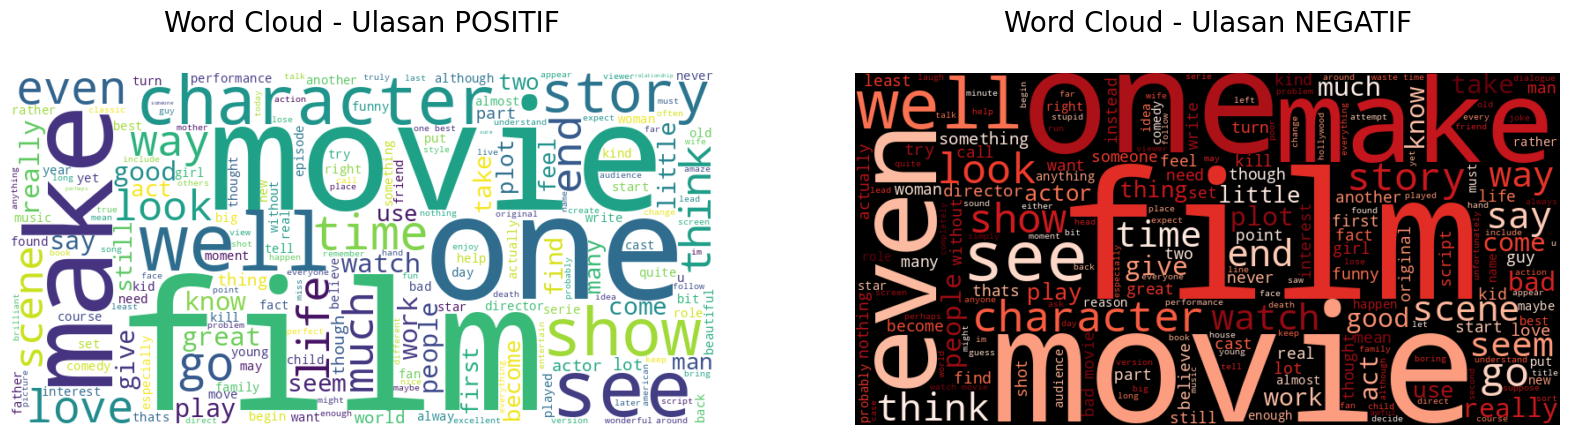

In [14]:
print("Membuat Word Cloud untuk sentimen Positif dan Negatif...")

# Gabungkan semua teks POSITIF
positive_text = ' '.join(df_train[df_train['sentimen'] == 'Positive']['clean_text'])
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)

# Gabungkan semua teks NEGATIF
negative_text = ' '.join(df_train[df_train['sentimen'] == 'Negative']['clean_text'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Tampilkan plotnya
plt.figure(figsize=(20, 10))

# Word Cloud Positif
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Word Cloud - Ulasan POSITIF\n', fontsize=20)
plt.axis('off')

# Word Cloud Negatif
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title('Word Cloud - Ulasan NEGATIF\n', fontsize=20)
plt.axis('off')

plt.show()

In [15]:
# Inisialisasi TF-IDF (mengikuti parameter di notebook-mu)
tfidf = TfidfVectorizer(max_features=1700, ngram_range=(1,2))

print("Menerapkan TF-IDF ke data training...")
# Fit transform data training
X_train = tfidf.fit_transform(df_train["clean_text"])
y_train = df_train["sentimen"]

print("Menerapkan TF-IDF ke data validasi...")
# Transform data validasi
X_test = tfidf.transform(df_val["clean_text"])
y_test = df_val["sentimen"]

print(f"\nBentuk X_train (TF-IDF): {X_train.shape}")
print(f"Bentuk X_test (TF-IDF): {X_test.shape}")

Menerapkan TF-IDF ke data training...
Menerapkan TF-IDF ke data validasi...

Bentuk X_train (TF-IDF): (24904, 1700)
Bentuk X_test (TF-IDF): (24801, 1700)


In [16]:
# Inisialisasi dan latih model (sama seperti kodemu)
model = LogisticRegression(max_iter=1000)
print("Melatih model Logistic Regression...")
model.fit(X_train, y_train)
print("Model selesai dilatih.")

Melatih model Logistic Regression...
Model selesai dilatih.


In [17]:
# Prediksi data test (validasi)
print("Memprediksi data validasi...")
y_predir = model.predict(X_test)
print("Prediksi selesai.")

Memprediksi data validasi...
Prediksi selesai.


In [18]:
# Tampilkan Accuracy
print("\n" + "="*40)
print(f"Accuracy Score: {accuracy_score(y_test, y_predir):.4f}")
print("="*40)

# Tampilkan Classification Report
# Karena hanya 2 kelas, laporannya akan lebih sederhana
print("\nClassification Report:\n")
print(classification_report(y_test, y_predir))


Accuracy Score: 0.8715

Classification Report:

              precision    recall  f1-score   support

    Negative       0.88      0.86      0.87     12361
    Positive       0.86      0.88      0.87     12440

    accuracy                           0.87     24801
   macro avg       0.87      0.87      0.87     24801
weighted avg       0.87      0.87      0.87     24801




Menampilkan Confusion Matrix...


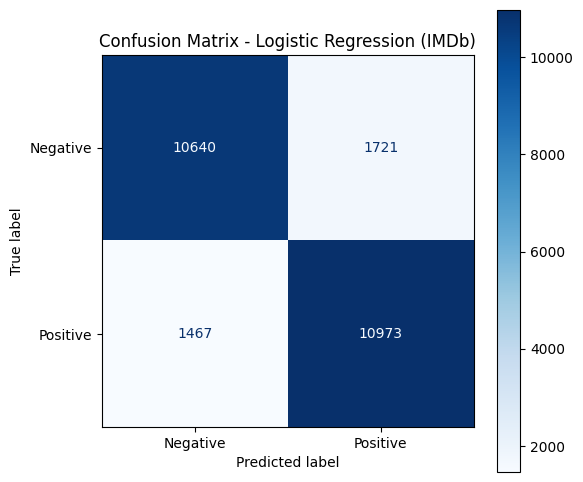

In [19]:
# Tampilkan Confusion Matrix
print("\nMenampilkan Confusion Matrix...")

cm = confusion_matrix(y_test, y_predir)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='horizontal')
plt.title('Confusion Matrix - Logistic Regression (IMDb)')
plt.show()

Menghitung skor probabilitas...
AUC Score: 0.9455
Menggambar ROC Curve...


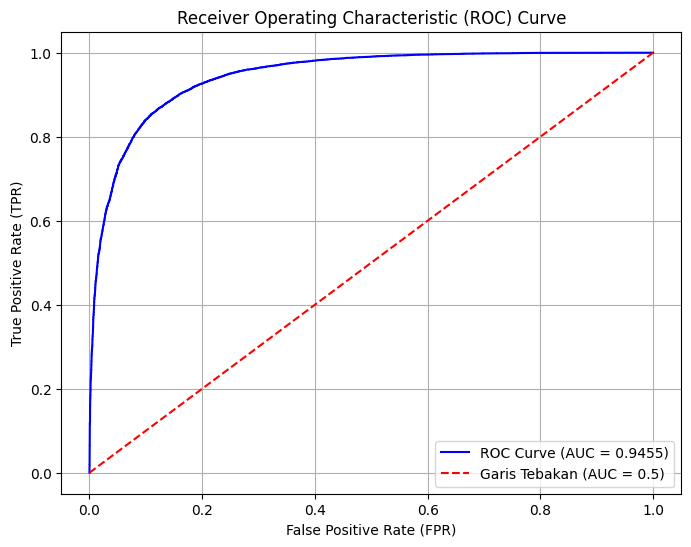

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

print("Menghitung skor probabilitas...")
# Kita ambil probabilitas untuk kelas 'Positive'
# [:, 1] artinya kita ambil kolom kedua (indeks 1)
y_probs = model.predict_proba(X_test)[:, 1]

# Hitung skor AUC (Area Under the Curve)
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}")

# Hitung FPR (False Positive Rate) dan TPR (True Positive Rate) untuk plot
# Kita perlu map y_test 'Positive'/'Negative' kembali ke 1/0 agar fungsi roc_curve bisa jalan
y_test_binary = y_test.map({'Positive': 1, 'Negative': 0})
fpr, tpr, thresholds = roc_curve(y_test_binary, y_probs)

print("Menggambar ROC Curve...")
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Garis Tebakan (AUC = 0.5)') # Garis tebakan acak
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()